In [10]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exp7 Pretrain Patch DCGAN to obtain feature extractor (fundus)

In [11]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from networks import weights_init, Generator_64, Discriminator_64, Generator_128_v2, Discriminator_128_v2, Discriminator_128_v2_PatchGAN, Discriminator_128_v2_DC_PatchGAN
from loader import All_fundus_files

In [12]:
# settings
dataroot = "data/celeba"
batch_size = 128
image_size = 128 #size using data aug.

ch_out = 3 
ch_noise = 100
ch_g = 64
ch_d = 64

num_epochs = 100
lr = 0.0002
beta1 = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
# dataloader
'''
train_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
'''
train_dataset = All_fundus_files(transform=transforms.Compose([
                           transforms.Resize(image_size),
                           transforms.CenterCrop(image_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
print(len(train_dataset))

# networks
#net_G = Generator_64(ch_noise, ch_g, ch_out).to(device)
net_G = Generator_128_v2(ch_noise, ch_g, ch_out).to(device)
net_G.apply(weights_init)
print(net_G)

#net_D = Discriminator_64(ch_out, ch_d).to(device)
net_D = Discriminator_128_v2_DC_PatchGAN(ch_out, ch_d).to(device)
net_D.apply(weights_init)
print(net_D)

# loss and optimizer
wei = 0.1
criterion = nn.BCELoss()
criterion2 = nn.MSELoss()
optimizer_D = optim.Adam(net_D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(net_G.parameters(), lr=lr, betas=(beta1, 0.999))
lr_scheduler_G = optim.lr_scheduler.MultiStepLR(optimizer_D, [20,60,90], gamma=0.1)
lr_scheduler_D = optim.lr_scheduler.MultiStepLR(optimizer_G, [20,60,90], gamma=0.1)

41317
41317
Generator_128_v2(
  (backbone): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=

In [5]:
from torchsummary import summary
summary(net_D, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
    InstanceNorm2d-4          [-1, 128, 32, 32]               0
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
    InstanceNorm2d-7          [-1, 256, 16, 16]               0
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
   InstanceNorm2d-10            [-1, 512, 8, 8]               0
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 4, 4]       8,388,608
   InstanceNorm2d-13           [-1, 1024, 4, 4]               0
        LeakyReLU-14           [-1, 102

In [14]:
def cv2_imwrite(path, image):
    image = np.clip(np.round(image*255),0,255)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

### Adding tricks to improve convergence
# https://github.com/soumith/ganhacks
# adding soft label and label noise
def train_one_epoch(epoch, dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device):
    G_losses = []
    D_losses = []
    for iteration, data in enumerate(dataloader, 0):
        ### Update D
        net_G.train()
        net_D.train()
        #data
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label_tmp = torch.rand((batch_size,))*0.5+0.7 #use soft label
        
        noise = torch.randn(batch_size, ch_noise, 1, 1, device=device) #(b,c,1,1)
        fake_data = net_G(noise)
        #fake_label = torch.zeros((batch_size,), dtype=torch.float, device=device)
        fake_label_tmp = torch.rand((batch_size,))*0.3
        
        if torch.rand(1) < 0.05: #add label noise
            real_label = fake_label_tmp.to(device)
            fake_label = real_label_tmp.to(device)
        else:
            real_label = real_label_tmp.to(device)
            fake_label = fake_label_tmp.to(device)
        
        #forward
        real_output, real_output2 = net_D(real_data)
        fake_output, fake_output2 = net_D(fake_data.detach())
        real_loss_D = criterion(real_output, real_label) + wei * criterion2(real_output2, real_label)
        fake_loss_D = criterion(fake_output, fake_label) + wei * criterion2(fake_output2, fake_label)
        loss_D = real_loss_D + fake_loss_D
        
        #backward
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        

        ### Update G
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label = torch.rand((batch_size,))*0.5+0.7
        real_label = real_label.to(device)
        fake_output_G, fake_output_G2 = net_D(fake_data)
        loss_G = criterion(fake_output_G, real_label) + wei * criterion2(fake_output_G2, real_label)
        
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        
        # logs
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        if iteration % 50 == 0:
            print('[{:d}/{:d}] Iter:{:d}  Loss_D={:.4f} Loss_G={:.4f} D(x)={:.4f} D(G(z))={:.4f}, {:.4f}'.format(
                  epoch, num_epochs, iteration+1, loss_D.item(), loss_G.item(), real_output.mean().item(), fake_output.mean().item(), fake_output_G.mean().item()))
        
        # test
        if (iteration == len(dataloader)//2) or (iteration == len(dataloader)-1):
            net_G.eval()
            net_D.eval()
            with torch.no_grad():
                fake_images = net_G(fixed_noise).detach().cpu()
            fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
            #print(fake_images)
            cv2_imwrite('./fig_exp7/epoch{}Iter{}.png'.format(epoch, iteration), fake_images.numpy())
    return G_losses, D_losses


In [15]:
# Training
G_losses = []
D_losses = []
fixed_noise = torch.randn(64, ch_noise, 1, 1, device=device)
# For each epoch
for epoch in range(num_epochs):
    g,d = train_one_epoch(epoch, train_dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device)
    G_losses += g
    D_losses += d
    lr_scheduler_G.step()
    lr_scheduler_D.step()

[0/100] Iter:1  Loss_D=2.9817 Loss_G=7.6135 D(x)=0.3415 D(G(z))=0.5706, 0.0012
[0/100] Iter:51  Loss_D=42.6394 Loss_G=70.7555 D(x)=0.0004 D(G(z))=0.0000, 0.0000
[0/100] Iter:101  Loss_D=2.8863 Loss_G=16.0403 D(x)=0.6611 D(G(z))=0.0008, 0.0003
[0/100] Iter:151  Loss_D=0.7612 Loss_G=2.8756 D(x)=0.9005 D(G(z))=0.2687, 0.0604
[0/100] Iter:201  Loss_D=0.7847 Loss_G=1.6406 D(x)=0.8543 D(G(z))=0.1873, 0.2090
[0/100] Iter:251  Loss_D=1.5219 Loss_G=1.2501 D(x)=0.4607 D(G(z))=0.0593, 0.2994
[0/100] Iter:301  Loss_D=0.7882 Loss_G=2.1946 D(x)=0.8631 D(G(z))=0.1839, 0.1191
[1/100] Iter:1  Loss_D=0.7104 Loss_G=2.1536 D(x)=0.9012 D(G(z))=0.2082, 0.1123
[1/100] Iter:51  Loss_D=1.0089 Loss_G=2.4292 D(x)=0.8343 D(G(z))=0.2291, 0.1195
[1/100] Iter:101  Loss_D=1.2046 Loss_G=0.9485 D(x)=0.6821 D(G(z))=0.5155, 0.3919
[1/100] Iter:151  Loss_D=0.9083 Loss_G=1.6199 D(x)=0.8151 D(G(z))=0.4339, 0.2049
[1/100] Iter:201  Loss_D=0.8642 Loss_G=2.8892 D(x)=0.8583 D(G(z))=0.4073, 0.0632
[1/100] Iter:251  Loss_D=1.2891

[14/100] Iter:201  Loss_D=0.9357 Loss_G=1.6303 D(x)=0.7184 D(G(z))=0.2526, 0.2596
[14/100] Iter:251  Loss_D=1.3947 Loss_G=0.6756 D(x)=0.4654 D(G(z))=0.3120, 0.5594
[14/100] Iter:301  Loss_D=0.9656 Loss_G=2.2016 D(x)=0.8555 D(G(z))=0.4130, 0.1569
[15/100] Iter:1  Loss_D=0.9941 Loss_G=1.6643 D(x)=0.7725 D(G(z))=0.3890, 0.2103
[15/100] Iter:51  Loss_D=1.3852 Loss_G=1.0069 D(x)=0.4971 D(G(z))=0.3860, 0.3996
[15/100] Iter:101  Loss_D=1.2937 Loss_G=1.9080 D(x)=0.9244 D(G(z))=0.6417, 0.1688
[15/100] Iter:151  Loss_D=1.1032 Loss_G=1.3575 D(x)=0.7847 D(G(z))=0.4921, 0.2889
[15/100] Iter:201  Loss_D=0.9676 Loss_G=1.6197 D(x)=0.7568 D(G(z))=0.3687, 0.2282
[15/100] Iter:251  Loss_D=3.1518 Loss_G=0.6681 D(x)=0.7556 D(G(z))=0.2330, 0.5529
[15/100] Iter:301  Loss_D=1.1171 Loss_G=1.2405 D(x)=0.6935 D(G(z))=0.4369, 0.3275
[16/100] Iter:1  Loss_D=0.9273 Loss_G=1.5931 D(x)=0.7455 D(G(z))=0.3247, 0.2224
[16/100] Iter:51  Loss_D=0.9556 Loss_G=1.6029 D(x)=0.8123 D(G(z))=0.4294, 0.2344
[16/100] Iter:101  Los

[29/100] Iter:1  Loss_D=0.7444 Loss_G=1.6040 D(x)=0.8494 D(G(z))=0.2187, 0.2090
[29/100] Iter:51  Loss_D=0.7818 Loss_G=1.4391 D(x)=0.7836 D(G(z))=0.2099, 0.2521
[29/100] Iter:101  Loss_D=0.7899 Loss_G=1.5852 D(x)=0.8885 D(G(z))=0.2850, 0.2173
[29/100] Iter:151  Loss_D=0.6969 Loss_G=1.5907 D(x)=0.8717 D(G(z))=0.2320, 0.2059
[29/100] Iter:201  Loss_D=0.8151 Loss_G=1.6478 D(x)=0.8277 D(G(z))=0.3254, 0.2057
[29/100] Iter:251  Loss_D=0.7815 Loss_G=1.4891 D(x)=0.8077 D(G(z))=0.2790, 0.2513
[29/100] Iter:301  Loss_D=3.4173 Loss_G=1.4505 D(x)=0.8218 D(G(z))=0.1836, 0.2493
[30/100] Iter:1  Loss_D=0.7672 Loss_G=1.5717 D(x)=0.8180 D(G(z))=0.2488, 0.2203
[30/100] Iter:51  Loss_D=0.7627 Loss_G=1.6181 D(x)=0.8237 D(G(z))=0.2071, 0.2150
[30/100] Iter:101  Loss_D=0.7016 Loss_G=1.7197 D(x)=0.8847 D(G(z))=0.2157, 0.1887
[30/100] Iter:151  Loss_D=2.4847 Loss_G=0.9421 D(x)=0.8393 D(G(z))=0.5167, 0.4145
[30/100] Iter:201  Loss_D=0.7399 Loss_G=1.6255 D(x)=0.8654 D(G(z))=0.2517, 0.2126
[30/100] Iter:251  Los

[43/100] Iter:151  Loss_D=0.7154 Loss_G=1.6289 D(x)=0.8504 D(G(z))=0.1681, 0.2035
[43/100] Iter:201  Loss_D=0.7358 Loss_G=1.4689 D(x)=0.7754 D(G(z))=0.1592, 0.2325
[43/100] Iter:251  Loss_D=0.8079 Loss_G=1.3530 D(x)=0.8014 D(G(z))=0.2785, 0.2816
[43/100] Iter:301  Loss_D=0.7223 Loss_G=1.8119 D(x)=0.8615 D(G(z))=0.2415, 0.1771
[44/100] Iter:1  Loss_D=0.8500 Loss_G=1.3990 D(x)=0.7550 D(G(z))=0.2382, 0.2624
[44/100] Iter:51  Loss_D=0.7955 Loss_G=1.3573 D(x)=0.7537 D(G(z))=0.2061, 0.2667
[44/100] Iter:101  Loss_D=0.7746 Loss_G=1.5287 D(x)=0.9149 D(G(z))=0.3457, 0.2367
[44/100] Iter:151  Loss_D=0.7579 Loss_G=1.3746 D(x)=0.8519 D(G(z))=0.2410, 0.2643
[44/100] Iter:201  Loss_D=0.6590 Loss_G=1.7251 D(x)=0.8379 D(G(z))=0.1604, 0.1915
[44/100] Iter:251  Loss_D=3.8667 Loss_G=1.3355 D(x)=0.9056 D(G(z))=0.2127, 0.2964
[44/100] Iter:301  Loss_D=0.8804 Loss_G=1.5643 D(x)=0.7214 D(G(z))=0.1491, 0.2152
[45/100] Iter:1  Loss_D=0.7391 Loss_G=1.7921 D(x)=0.9112 D(G(z))=0.2783, 0.1830
[45/100] Iter:51  Los

[57/100] Iter:301  Loss_D=0.8949 Loss_G=1.6422 D(x)=0.8912 D(G(z))=0.4302, 0.2171
[58/100] Iter:1  Loss_D=0.8983 Loss_G=1.5670 D(x)=0.7062 D(G(z))=0.1877, 0.2247
[58/100] Iter:51  Loss_D=0.7617 Loss_G=1.5145 D(x)=0.7800 D(G(z))=0.1599, 0.2288
[58/100] Iter:101  Loss_D=0.7638 Loss_G=1.6526 D(x)=0.7838 D(G(z))=0.1907, 0.2018
[58/100] Iter:151  Loss_D=0.9282 Loss_G=1.2116 D(x)=0.6684 D(G(z))=0.2432, 0.3149
[58/100] Iter:201  Loss_D=0.7509 Loss_G=1.3896 D(x)=0.8312 D(G(z))=0.2258, 0.2665
[58/100] Iter:251  Loss_D=0.7295 Loss_G=1.6611 D(x)=0.8289 D(G(z))=0.1496, 0.2013
[58/100] Iter:301  Loss_D=0.6950 Loss_G=1.4671 D(x)=0.8890 D(G(z))=0.2789, 0.2421
[59/100] Iter:1  Loss_D=0.7615 Loss_G=1.6195 D(x)=0.8913 D(G(z))=0.3168, 0.2152
[59/100] Iter:51  Loss_D=0.6654 Loss_G=1.7337 D(x)=0.9005 D(G(z))=0.2176, 0.1903
[59/100] Iter:101  Loss_D=0.7205 Loss_G=1.8153 D(x)=0.8829 D(G(z))=0.1599, 0.1669
[59/100] Iter:151  Loss_D=0.7600 Loss_G=1.3008 D(x)=0.8720 D(G(z))=0.3208, 0.2863
[59/100] Iter:201  Los

[72/100] Iter:101  Loss_D=0.7868 Loss_G=1.4166 D(x)=0.8234 D(G(z))=0.2490, 0.2498
[72/100] Iter:151  Loss_D=0.7059 Loss_G=1.5477 D(x)=0.8731 D(G(z))=0.2195, 0.2195
[72/100] Iter:201  Loss_D=0.7590 Loss_G=1.3296 D(x)=0.8307 D(G(z))=0.2662, 0.2679
[72/100] Iter:251  Loss_D=0.7752 Loss_G=1.3330 D(x)=0.8364 D(G(z))=0.2833, 0.2835
[72/100] Iter:301  Loss_D=0.6961 Loss_G=1.6686 D(x)=0.8367 D(G(z))=0.1963, 0.1962
[73/100] Iter:1  Loss_D=0.6950 Loss_G=1.5612 D(x)=0.8255 D(G(z))=0.2137, 0.2159
[73/100] Iter:51  Loss_D=0.6970 Loss_G=1.7724 D(x)=0.8485 D(G(z))=0.1704, 0.1799
[73/100] Iter:101  Loss_D=0.7131 Loss_G=1.6070 D(x)=0.8213 D(G(z))=0.1950, 0.1981
[73/100] Iter:151  Loss_D=0.7581 Loss_G=1.3486 D(x)=0.9391 D(G(z))=0.2832, 0.2714
[73/100] Iter:201  Loss_D=0.7241 Loss_G=1.6318 D(x)=0.8411 D(G(z))=0.2019, 0.2083
[73/100] Iter:251  Loss_D=0.7065 Loss_G=1.6683 D(x)=0.8922 D(G(z))=0.1971, 0.1926
[73/100] Iter:301  Loss_D=0.6882 Loss_G=1.2301 D(x)=0.8780 D(G(z))=0.3201, 0.3115
[74/100] Iter:1  Lo

[86/100] Iter:251  Loss_D=0.7193 Loss_G=1.5177 D(x)=0.8808 D(G(z))=0.2400, 0.2344
[86/100] Iter:301  Loss_D=0.7004 Loss_G=1.5217 D(x)=0.8628 D(G(z))=0.2284, 0.2304
[87/100] Iter:1  Loss_D=0.8102 Loss_G=1.3628 D(x)=0.7753 D(G(z))=0.2545, 0.2654
[87/100] Iter:51  Loss_D=0.6475 Loss_G=1.6779 D(x)=0.8998 D(G(z))=0.1943, 0.1917
[87/100] Iter:101  Loss_D=3.4283 Loss_G=1.5880 D(x)=0.8503 D(G(z))=0.1983, 0.2116
[87/100] Iter:151  Loss_D=3.0956 Loss_G=1.2553 D(x)=0.8599 D(G(z))=0.2948, 0.2964
[87/100] Iter:201  Loss_D=0.6942 Loss_G=1.5673 D(x)=0.9045 D(G(z))=0.2142, 0.2130
[87/100] Iter:251  Loss_D=0.7705 Loss_G=1.3524 D(x)=0.8916 D(G(z))=0.2856, 0.2741
[87/100] Iter:301  Loss_D=0.7183 Loss_G=1.6687 D(x)=0.8670 D(G(z))=0.1886, 0.1940
[88/100] Iter:1  Loss_D=0.7572 Loss_G=1.3509 D(x)=0.9031 D(G(z))=0.2892, 0.2774
[88/100] Iter:51  Loss_D=2.7179 Loss_G=0.9332 D(x)=0.8583 D(G(z))=0.4392, 0.4220
[88/100] Iter:101  Loss_D=0.8357 Loss_G=1.0283 D(x)=0.8917 D(G(z))=0.4031, 0.3681
[88/100] Iter:151  Los

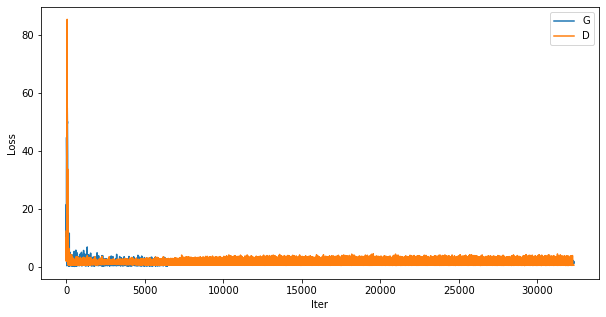

In [16]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

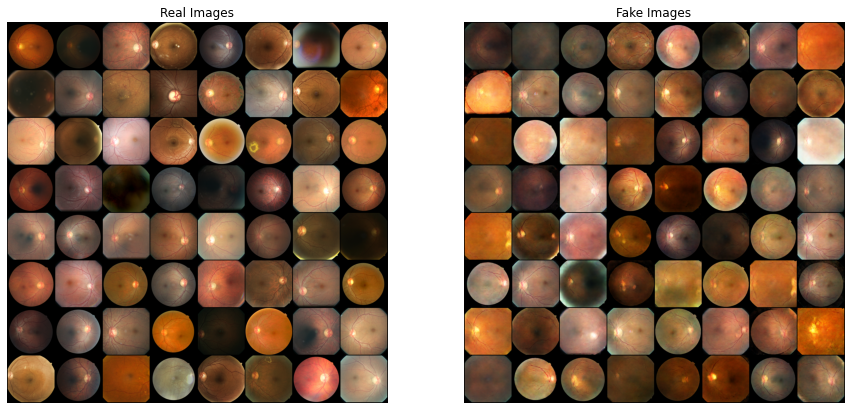

In [17]:
# check images
real_images = next(iter(train_dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Real Images")

plt.subplot(1,2,2)
fake_images = net_G(fixed_noise).detach().cpu()
fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
plt.imshow(fake_images)
plt.axis("off")
plt.title("Fake Images")
plt.show()

In [18]:
#Save
state = {
    'net': net_D.state_dict(),
    'acc': 0,
    'epoch': num_epochs,
}
if not os.path.isdir('checkpoint/exp7'):
    os.mkdir('checkpoint/exp7')
torch.save(state, './checkpoint/exp7/ckpt.pth')